## 1. Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
import glob

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.formatter.use_locale'] = True

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Atualizado para usar pasta BASE DE DADOS
DATA_PATH = Path('BASE DE DADOS')

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.4.0


## 2. Carregamento e Dicionário de Dados

In [ ]:
# =============================================================================
# CARREGAR DADOS DO SINAN - DENGUE 2025
# Para analise temporal detalhada, uso o ano mais recente (2025)
# A analise consolidada de todos os anos esta em analise_dengue.ipynb
# =============================================================================

print("Carregando dados do SINAN (base 2025)...")

# Usar arquivo de 2025 para analise temporal detalhada
arquivo_2025 = DATA_PATH / 'DENGBR25.csv'
df = pd.read_csv(arquivo_2025, encoding='latin-1', low_memory=False)
df['ANO_BASE'] = 2025

print(f"\n{'='*60}")
print(f"Dataset carregado!")
print(f"Dimensoes: {df.shape[0]:,} linhas x {df.shape[1]} colunas")
print(f"Ano: 2025")

Carregando dados do SINAN (base 2025)...

Dataset carregado!
Dimensoes: 1,668,787 linhas x 122 colunas
Ano: 2025


In [4]:
# =============================================================================
# DICIONÁRIO DE VARIÁVEIS TEMPORAIS
# =============================================================================

dicionario_temporal = {
    'DT_NOTIFIC': 'Data de notificação (entrada no sistema)',
    'DT_SIN_PRI': 'Data dos primeiros sintomas (t0)',
    'DT_INVEST': 'Data de investigação',
    'DT_ALRM': 'Data de início dos sinais de alarme',
    'DT_GRAV': 'Data de evolução para gravidade',
    'DT_INTERNA': 'Data de internação',
    'DT_OBITO': 'Data de óbito',
    'DT_ENCERRA': 'Data de encerramento do caso',
    'SEM_NOT': 'Semana epidemiológica da notificação',
    'SEM_PRI': 'Semana epidemiológica dos primeiros sintomas'
}

dicionario_desfecho = {
    'EVOLUCAO': {
        1: 'Cura',
        2: 'Óbito por dengue',
        3: 'Óbito por outras causas',
        9: 'Ignorado'
    },
    'CLASSI_FIN': {
        1: 'Dengue',
        2: 'Dengue com sinais de alarme',
        3: 'Dengue grave',
        4: 'Descartado',
        10: 'Dengue clássico',
        11: 'Dengue com complicações',
        12: 'Síndrome de choque'
    },
    'HOSPITALIZ': {
        1: 'Sim',
        2: 'Não'
    }
}

print("=" * 60)
print("DICIONÁRIO DE VARIÁVEIS TEMPORAIS")
print("=" * 60)
for var, desc in dicionario_temporal.items():
    print(f"  {var}: {desc}")

DICIONÁRIO DE VARIÁVEIS TEMPORAIS
  DT_NOTIFIC: Data de notificação (entrada no sistema)
  DT_SIN_PRI: Data dos primeiros sintomas (t0)
  DT_INVEST: Data de investigação
  DT_ALRM: Data de início dos sinais de alarme
  DT_GRAV: Data de evolução para gravidade
  DT_INTERNA: Data de internação
  DT_OBITO: Data de óbito
  DT_ENCERRA: Data de encerramento do caso
  SEM_NOT: Semana epidemiológica da notificação
  SEM_PRI: Semana epidemiológica dos primeiros sintomas


In [5]:
# =============================================================================
# VERIFICAÇÃO DE VARIÁVEIS TEMPORAIS DISPONÍVEIS
# =============================================================================

print("\nVARIÁVEIS TEMPORAIS DISPONÍVEIS NO DATASET:")
print("-" * 60)

colunas_temporais = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_INVEST', 'DT_ALRM', 
                     'DT_GRAV', 'DT_INTERNA', 'DT_OBITO', 'DT_ENCERRA']

for col in colunas_temporais:
    if col in df.columns:
        n_preenchidos = df[col].notna().sum()
        pct = n_preenchidos / len(df) * 100
        print(f"  {col}: {n_preenchidos:,} registros ({pct:.1f}%)")
    else:
        print(f"  {col}: NÃO ENCONTRADA")


VARIÁVEIS TEMPORAIS DISPONÍVEIS NO DATASET:
------------------------------------------------------------
  DT_NOTIFIC: 1,668,787 registros (100.0%)
  DT_SIN_PRI: 1,668,787 registros (100.0%)
  DT_INVEST: 1,603,531 registros (96.1%)
  DT_ALRM: 37,891 registros (2.3%)
  DT_GRAV: 2,889 registros (0.2%)
  DT_INTERNA: 66,647 registros (4.0%)
  DT_OBITO: 2,445 registros (0.1%)
  DT_ENCERRA: 1,611,093 registros (96.5%)


## 3. Engenharia Temporal

In [6]:
# =============================================================================
# CONVERSÃO DE DATAS E CRIAÇÃO DE FEATURES TEMPORAIS
# =============================================================================

print("Convertendo colunas de data...")

# Lista de colunas de data para converter
colunas_data = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_INVEST', 'DT_ALRM', 
                'DT_GRAV', 'DT_INTERNA', 'DT_OBITO', 'DT_ENCERRA']

for col in colunas_data:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
        print(f"  [OK] {col} convertida")

# Verificar intervalo de datas
print("\nIntervalo de dados:")
print(f"  DT_SIN_PRI: {df['DT_SIN_PRI'].min()} até {df['DT_SIN_PRI'].max()}")

Convertendo colunas de data...
  [OK] DT_NOTIFIC convertida
  [OK] DT_SIN_PRI convertida
  [OK] DT_INVEST convertida
  [OK] DT_ALRM convertida
  [OK] DT_GRAV convertida
  [OK] DT_INTERNA convertida
  [OK] DT_OBITO convertida
  [OK] DT_ENCERRA convertida

Intervalo de dados:
  DT_SIN_PRI: 2024-12-29 00:00:00 até 2026-01-03 00:00:00


In [7]:
# =============================================================================
# CRIAÇÃO DE VARIÁVEIS DERIVADAS - DELTAS TEMPORAIS
# =============================================================================

print("Calculando deltas temporais...")

# Delta: t0 (primeiros sintomas) → Notificação
df['DELTA_SINTOMAS_NOTIFIC'] = (df['DT_NOTIFIC'] - df['DT_SIN_PRI']).dt.days

# Delta: t0 → Sinais de Alarme
if 'DT_ALRM' in df.columns:
    df['DELTA_SINTOMAS_ALARME'] = (df['DT_ALRM'] - df['DT_SIN_PRI']).dt.days

# Delta: t0 → Gravidade
if 'DT_GRAV' in df.columns:
    df['DELTA_SINTOMAS_GRAV'] = (df['DT_GRAV'] - df['DT_SIN_PRI']).dt.days

# Delta: t0 → Internação
if 'DT_INTERNA' in df.columns:
    df['DELTA_SINTOMAS_INTERNA'] = (df['DT_INTERNA'] - df['DT_SIN_PRI']).dt.days

# Delta: t0 → Óbito
if 'DT_OBITO' in df.columns:
    df['DELTA_SINTOMAS_OBITO'] = (df['DT_OBITO'] - df['DT_SIN_PRI']).dt.days

# Delta: Alarme → Gravidade
if 'DT_ALRM' in df.columns and 'DT_GRAV' in df.columns:
    df['DELTA_ALARME_GRAV'] = (df['DT_GRAV'] - df['DT_ALRM']).dt.days

# Delta: Internação → Óbito
if 'DT_INTERNA' in df.columns and 'DT_OBITO' in df.columns:
    df['DELTA_INTERNA_OBITO'] = (df['DT_OBITO'] - df['DT_INTERNA']).dt.days

print("\n[OK] Deltas calculados")

# Listar deltas criados
deltas = [col for col in df.columns if col.startswith('DELTA_')]
print(f"\nVariáveis de delta criadas: {deltas}")

Calculando deltas temporais...

[OK] Deltas calculados

Variáveis de delta criadas: ['DELTA_SINTOMAS_NOTIFIC', 'DELTA_SINTOMAS_ALARME', 'DELTA_SINTOMAS_GRAV', 'DELTA_SINTOMAS_INTERNA', 'DELTA_SINTOMAS_OBITO', 'DELTA_ALARME_GRAV', 'DELTA_INTERNA_OBITO']


In [8]:
# =============================================================================
# CRIAÇÃO DE FAIXA ETÁRIA E OUTROS ESTRATIFICADORES
# =============================================================================

def calcular_idade(nu_idade_n):
    """Converte código SINAN para idade em anos"""
    if pd.isna(nu_idade_n):
        return None
    try:
        codigo = str(int(nu_idade_n))
        if len(codigo) != 4:
            return None
        tipo = int(codigo[0])
        valor = int(codigo[1:])
        if tipo == 4:  # Anos
            return valor
        elif tipo == 3:  # Meses
            return valor / 12
        elif tipo == 2:  # Dias
            return valor / 365
        elif tipo == 1:  # Horas
            return valor / (365 * 24)
    except:
        return None
    return None

def classificar_faixa_etaria(idade):
    """Classifica idade em faixas"""
    if pd.isna(idade):
        return 'Desconhecida'
    if idade < 15:
        return 'Criança (0-14)'
    elif idade < 23:
        return 'Jovem (15-22)'
    elif idade < 60:
        return 'Adulto (23-59)'
    else:
        return 'Idoso (60+)'

# Aplicar transformações
df['IDADE_ANOS'] = df['NU_IDADE_N'].apply(calcular_idade)
df['FAIXA_ETARIA'] = df['IDADE_ANOS'].apply(classificar_faixa_etaria)

# Sexo
df['SEXO'] = df['CS_SEXO'].map({'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'})

# Região (baseado na UF)
UF_REGIAO = {
    'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}
df['REGIAO'] = df['SG_UF_NOT'].map(UF_REGIAO)

print("[OK] Variáveis de estratificação criadas")
print(f"\nDistribuição por faixa etária:")
print(df['FAIXA_ETARIA'].value_counts())

[OK] Variáveis de estratificação criadas

Distribuição por faixa etária:
FAIXA_ETARIA
Adulto (23-59)    950136
Criança (0-14)    252169
Idoso (60+)       237379
Jovem (15-22)     229096
Desconhecida           7
Name: count, dtype: int64


In [9]:
# =============================================================================
# TRATAMENTO DE INCONSISTÊNCIAS TEMPORAIS
# =============================================================================

print("Verificando inconsistências temporais...")

# Filtrar deltas negativos (inconsistências)
for delta_col in deltas:
    if delta_col in df.columns:
        negativos = (df[delta_col] < 0).sum()
        if negativos > 0:
            print(f"  [AVISO] {delta_col}: {negativos:,} valores negativos (removidos)")
            df.loc[df[delta_col] < 0, delta_col] = np.nan

# Filtrar deltas muito grandes (> 60 dias) - provavelmente erros
DELTA_MAX_DIAS = 60

for delta_col in deltas:
    if delta_col in df.columns:
        grandes = (df[delta_col] > DELTA_MAX_DIAS).sum()
        if grandes > 0:
            print(f"  [AVISO] {delta_col}: {grandes:,} valores > {DELTA_MAX_DIAS} dias (removidos)")
            df.loc[df[delta_col] > DELTA_MAX_DIAS, delta_col] = np.nan

print("\n[OK] Inconsistências tratadas")

Verificando inconsistências temporais...
  [AVISO] DELTA_SINTOMAS_ALARME: 908 valores negativos (removidos)
  [AVISO] DELTA_SINTOMAS_GRAV: 67 valores negativos (removidos)
  [AVISO] DELTA_SINTOMAS_INTERNA: 1,477 valores negativos (removidos)
  [AVISO] DELTA_ALARME_GRAV: 107 valores negativos (removidos)
  [AVISO] DELTA_INTERNA_OBITO: 6 valores negativos (removidos)
  [AVISO] DELTA_SINTOMAS_NOTIFIC: 8,236 valores > 60 dias (removidos)
  [AVISO] DELTA_SINTOMAS_ALARME: 114 valores > 60 dias (removidos)
  [AVISO] DELTA_SINTOMAS_GRAV: 13 valores > 60 dias (removidos)
  [AVISO] DELTA_SINTOMAS_INTERNA: 96 valores > 60 dias (removidos)
  [AVISO] DELTA_SINTOMAS_OBITO: 23 valores > 60 dias (removidos)
  [AVISO] DELTA_ALARME_GRAV: 17 valores > 60 dias (removidos)
  [AVISO] DELTA_INTERNA_OBITO: 23 valores > 60 dias (removidos)

[OK] Inconsistências tratadas


## 4. Análise de Evolução Temporal

In [10]:
# =============================================================================
# MÉTRICAS TEMPORAIS GLOBAIS
# =============================================================================

print("=" * 60)
print("MÉTRICAS DE EVOLUÇÃO TEMPORAL - VISÃO GERAL")
print("=" * 60)

metricas_temporais = {}

for delta_col in deltas:
    if delta_col in df.columns:
        dados = df[delta_col].dropna()
        if len(dados) > 0:
            metricas = {
                'n': len(dados),
                'media': dados.mean(),
                'mediana': dados.median(),
                'std': dados.std(),
                'p25': dados.quantile(0.25),
                'p75': dados.quantile(0.75),
                'p90': dados.quantile(0.90)
            }
            metricas_temporais[delta_col] = metricas
            
            print(f"\n{delta_col}:")
            print(f"  N casos: {metricas['n']:,}")
            print(f"  Média: {metricas['media']:.1f} dias")
            print(f"  Mediana: {metricas['mediana']:.1f} dias")
            print(f"  Percentil 25-75: {metricas['p25']:.1f} - {metricas['p75']:.1f} dias")
            print(f"  Percentil 90: {metricas['p90']:.1f} dias")

MÉTRICAS DE EVOLUÇÃO TEMPORAL - VISÃO GERAL

DELTA_SINTOMAS_NOTIFIC:
  N casos: 1,660,551
  Média: 3.7 dias
  Mediana: 3.0 dias
  Percentil 25-75: 1.0 - 4.0 dias
  Percentil 90: 7.0 dias

DELTA_SINTOMAS_ALARME:
  N casos: 36,869
  Média: 3.7 dias
  Mediana: 3.0 dias
  Percentil 25-75: 0.0 - 5.0 dias
  Percentil 90: 7.0 dias

DELTA_SINTOMAS_GRAV:
  N casos: 2,809
  Média: 4.9 dias
  Mediana: 4.0 dias
  Percentil 25-75: 2.0 - 6.0 dias
  Percentil 90: 9.0 dias

DELTA_SINTOMAS_INTERNA:
  N casos: 65,074
  Média: 4.4 dias
  Mediana: 4.0 dias
  Percentil 25-75: 2.0 - 6.0 dias
  Percentil 90: 7.0 dias

DELTA_SINTOMAS_OBITO:
  N casos: 2,422
  Média: 10.8 dias
  Mediana: 7.0 dias
  Percentil 25-75: 5.0 - 14.0 dias
  Percentil 90: 23.0 dias

DELTA_ALARME_GRAV:
  N casos: 2,458
  Média: 1.2 dias
  Mediana: 0.0 dias
  Percentil 25-75: 0.0 - 1.0 dias
  Percentil 90: 3.0 dias

DELTA_INTERNA_OBITO:
  N casos: 1,946
  Média: 7.0 dias
  Mediana: 3.0 dias
  Percentil 25-75: 1.0 - 10.0 dias
  Percentil 

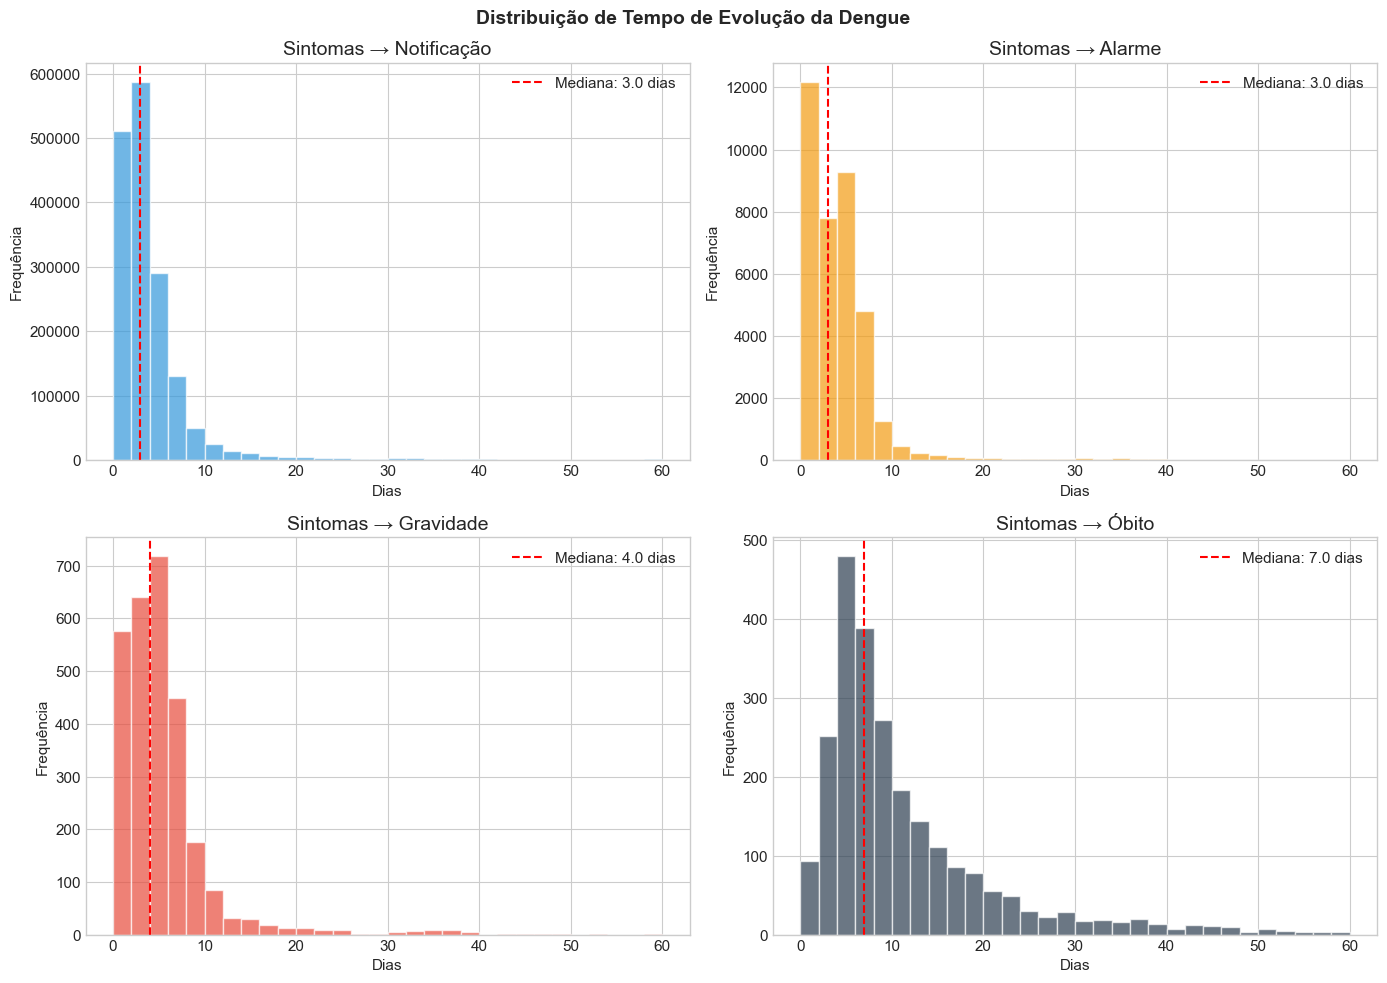

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribuição de Tempo de Evolução da Dengue', fontsize=14, fontweight='bold')

delta_vars = [
    ('DELTA_SINTOMAS_NOTIFIC', 'Sintomas → Notificação', '#3498db'),
    ('DELTA_SINTOMAS_ALARME', 'Sintomas → Alarme', '#f39c12'),
    ('DELTA_SINTOMAS_GRAV', 'Sintomas → Gravidade', '#e74c3c'),
    ('DELTA_SINTOMAS_OBITO', 'Sintomas → Óbito', '#2c3e50')
]

for ax, (var, title, color) in zip(axes.flat, delta_vars):
    if var in df.columns:
        dados = df[var].dropna()
        if len(dados) > 0:
            ax.hist(dados, bins=30, color=color, alpha=0.7, edgecolor='white')
            ax.axvline(dados.median(), color='red', linestyle='--', 
                      label=f'Mediana: {dados.median():.1f} dias')
            ax.set_xlabel('Dias')
            ax.set_ylabel('Frequência')
            ax.set_title(title)
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'Sem dados', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
    else:
        ax.text(0.5, 0.5, 'Variável não disponível', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)

plt.tight_layout()
plt.show()

In [12]:
# =============================================================================
# ESTRATIFICAÇÃO POR FAIXA ETÁRIA
# =============================================================================

print("=" * 60)
print("EVOLUÇÃO TEMPORAL POR FAIXA ETÁRIA")
print("=" * 60)

# Métricas por faixa etária
faixas_ordem = ['Criança (0-14)', 'Jovem (15-22)', 'Adulto (23-59)', 'Idoso (60+)']

resultados_faixa = []

for faixa in faixas_ordem:
    df_faixa = df[df['FAIXA_ETARIA'] == faixa]
    n_total = len(df_faixa)
    
    if n_total > 0:
        resultado = {
            'faixa_etaria': faixa,
            'n_casos': n_total
        }
        
        # Calcular métricas para cada delta
        for delta_col in ['DELTA_SINTOMAS_ALARME', 'DELTA_SINTOMAS_GRAV', 'DELTA_SINTOMAS_OBITO']:
            if delta_col in df.columns:
                dados = df_faixa[delta_col].dropna()
                if len(dados) > 0:
                    resultado[f'{delta_col}_n'] = len(dados)
                    resultado[f'{delta_col}_media'] = dados.mean()
                    resultado[f'{delta_col}_mediana'] = dados.median()
        
        resultados_faixa.append(resultado)

df_metricas_faixa = pd.DataFrame(resultados_faixa)
print(df_metricas_faixa.to_string())

EVOLUÇÃO TEMPORAL POR FAIXA ETÁRIA
     faixa_etaria  n_casos  DELTA_SINTOMAS_ALARME_n  DELTA_SINTOMAS_ALARME_media  DELTA_SINTOMAS_ALARME_mediana  DELTA_SINTOMAS_GRAV_n  DELTA_SINTOMAS_GRAV_media  DELTA_SINTOMAS_GRAV_mediana  DELTA_SINTOMAS_OBITO_n  DELTA_SINTOMAS_OBITO_media  DELTA_SINTOMAS_OBITO_mediana
0  Criança (0-14)   252169                     5215                     3.188686                            2.0                    261                   4.107280                          4.0                      92                    8.413043                           6.0
1   Jovem (15-22)   229096                     3826                     3.565604                            3.0                    203                   4.512315                          4.0                      69                    9.347826                           7.0
2  Adulto (23-59)   950136                    19192                     3.717799                            3.0                   1200            

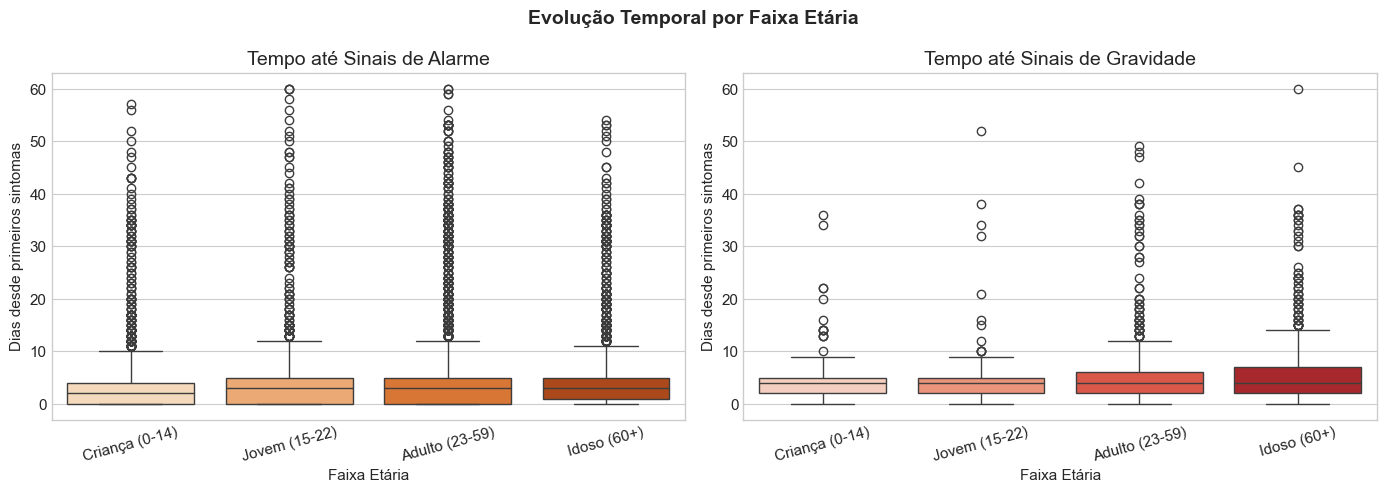

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Evolução Temporal por Faixa Etária', fontsize=14, fontweight='bold')

faixas_ordem = ['Criança (0-14)', 'Jovem (15-22)', 'Adulto (23-59)', 'Idoso (60+)']

df_plot = df.dropna(subset=['FAIXA_ETARIA'])

if 'DELTA_SINTOMAS_ALARME' in df.columns:
    dados_alarme = df_plot.dropna(subset=['DELTA_SINTOMAS_ALARME'])
    if len(dados_alarme) > 0:
        sns.boxplot(data=dados_alarme, x='FAIXA_ETARIA', y='DELTA_SINTOMAS_ALARME', 
                   order=faixas_ordem, ax=axes[0], palette='Oranges')
        axes[0].set_title('Tempo até Sinais de Alarme')
        axes[0].set_xlabel('Faixa Etária')
        axes[0].set_ylabel('Dias desde primeiros sintomas')
        axes[0].tick_params(axis='x', rotation=15)
    else:
        axes[0].text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        axes[0].set_title('Tempo até Sinais de Alarme')

if 'DELTA_SINTOMAS_GRAV' in df.columns:
    dados_grav = df_plot.dropna(subset=['DELTA_SINTOMAS_GRAV'])
    if len(dados_grav) > 0:
        sns.boxplot(data=dados_grav, x='FAIXA_ETARIA', y='DELTA_SINTOMAS_GRAV', 
                   order=faixas_ordem, ax=axes[1], palette='Reds')
        axes[1].set_title('Tempo até Sinais de Gravidade')
        axes[1].set_xlabel('Faixa Etária')
        axes[1].set_ylabel('Dias desde primeiros sintomas')
        axes[1].tick_params(axis='x', rotation=15)
    else:
        axes[1].text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        axes[1].set_title('Tempo até Sinais de Gravidade')

plt.tight_layout()
plt.show()

## 5. Análise de Fatores de Risco Temporais

In [14]:
# =============================================================================
# ANÁLISE: SINTOMAS INICIAIS VS EVOLUÇÃO
# =============================================================================

print("=" * 60)
print("SINTOMAS NO INÍCIO VS TEMPO DE EVOLUÇÃO")
print("=" * 60)

# Sintomas a analisar
sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'VOMITO', 'NAUSEA', 'DOR_RETRO', 'ARTRALGIA']

# Filtrar casos com gravidade documentada
df_grave = df[df['DELTA_SINTOMAS_GRAV'].notna()].copy()

if len(df_grave) > 0:
    resultados_sintomas = []
    
    for sintoma in sintomas:
        if sintoma in df_grave.columns:
            # Casos COM o sintoma (valor 1)
            com_sintoma = df_grave[df_grave[sintoma] == 1]['DELTA_SINTOMAS_GRAV']
            # Casos SEM o sintoma (valor 2)
            sem_sintoma = df_grave[df_grave[sintoma] == 2]['DELTA_SINTOMAS_GRAV']
            
            if len(com_sintoma) > 10 and len(sem_sintoma) > 10:
                resultado = {
                    'sintoma': sintoma,
                    'n_com': len(com_sintoma),
                    'media_com': com_sintoma.mean(),
                    'n_sem': len(sem_sintoma),
                    'media_sem': sem_sintoma.mean(),
                    'diferenca': com_sintoma.mean() - sem_sintoma.mean()
                }
                resultados_sintomas.append(resultado)
    
    df_sintomas_tempo = pd.DataFrame(resultados_sintomas)
    df_sintomas_tempo = df_sintomas_tempo.sort_values('diferenca')
    
    print("\nTempo médio até gravidade (dias):")
    print(df_sintomas_tempo.to_string(index=False))
    
    print("\n[NOTA] Insight: Sintomas com 'diferença' negativa indicam")
    print("   evolução MAIS RÁPIDA para gravidade quando presentes")
else:
    print("[AVISO] Dados insuficientes para análise de sintomas vs tempo de evolução")

SINTOMAS NO INÍCIO VS TEMPO DE EVOLUÇÃO

Tempo médio até gravidade (dias):
  sintoma  n_com  media_com  n_sem  media_sem  diferenca
DOR_RETRO    595   4.768067   2214   4.988257  -0.220189
 CEFALEIA   1707   4.888694   1102   5.023593  -0.134900
   NAUSEA   1444   4.878809   1365   5.008059  -0.129250
    FEBRE   2249   4.937750    560   4.957143  -0.019393
   VOMITO   1271   4.959087   1538   4.927178   0.031909
  MIALGIA   2049   4.977062    760   4.846053   0.131009
ARTRALGIA    488   5.081967   2321   4.912107   0.169860

[NOTA] Insight: Sintomas com 'diferença' negativa indicam
   evolução MAIS RÁPIDA para gravidade quando presentes


In [15]:
# =============================================================================
# ANÁLISE: COMORBIDADES VS EVOLUÇÃO
# =============================================================================

print("=" * 60)
print("COMORBIDADES VS TEMPO DE EVOLUÇÃO")
print("=" * 60)

comorbidades = ['DIABETES', 'HIPERTENSA', 'HEPATOPAT', 'RENAL', 'HEMATOLOG']

if len(df_grave) > 0:
    resultados_comorb = []
    
    for comorb in comorbidades:
        if comorb in df_grave.columns:
            com_comorb = df_grave[df_grave[comorb] == 1]['DELTA_SINTOMAS_GRAV']
            sem_comorb = df_grave[df_grave[comorb] == 2]['DELTA_SINTOMAS_GRAV']
            
            if len(com_comorb) > 5 and len(sem_comorb) > 5:
                resultado = {
                    'comorbidade': comorb,
                    'n_com': len(com_comorb),
                    'media_com': com_comorb.mean(),
                    'mediana_com': com_comorb.median(),
                    'n_sem': len(sem_comorb),
                    'media_sem': sem_comorb.mean(),
                    'diferenca': com_comorb.mean() - sem_comorb.mean()
                }
                resultados_comorb.append(resultado)
    
    if resultados_comorb:
        df_comorb_tempo = pd.DataFrame(resultados_comorb)
        df_comorb_tempo = df_comorb_tempo.sort_values('diferenca')
        print("\nTempo médio até gravidade (dias):")
        print(df_comorb_tempo.to_string(index=False))
    else:
        print("[AVISO] Dados insuficientes para análise de comorbidades")

COMORBIDADES VS TEMPO DE EVOLUÇÃO

Tempo médio até gravidade (dias):
comorbidade  n_com  media_com  mediana_com  n_sem  media_sem  diferenca
  HEPATOPAT     75   4.786667          3.0   2734   4.945867  -0.159200
   DIABETES    578   4.953287          4.0   2231   4.938593   0.014695
      RENAL    142   5.197183          4.0   2667   4.928009   0.269174
 HIPERTENSA    982   5.214868          4.0   1827   4.794745   0.420122
  HEMATOLOG     93   5.806452          4.0   2716   4.912003   0.894449


## 6. Geração de Features para o RAG

In [16]:
# =============================================================================
# CRIAÇÃO DE FEATURES AGREGADAS PARA O RAG
# =============================================================================

print("=" * 60)
print("GERANDO FEATURES PARA O SISTEMA RAG")
print("=" * 60)

# Feature 1: Métricas temporais por perfil
perfis_temporais = []

for faixa in faixas_ordem:
    for sexo in ['Masculino', 'Feminino']:
        df_perfil = df[(df['FAIXA_ETARIA'] == faixa) & (df['SEXO'] == sexo)]
        
        if len(df_perfil) >= 100:  # Mínimo de casos para robustez
            perfil = {
                'faixa_etaria': faixa,
                'sexo': sexo,
                'n_casos': len(df_perfil)
            }
            
            # Taxa de hospitalização
            perfil['taxa_hospitalizacao'] = (df_perfil['HOSPITALIZ'] == 1).mean()
            
            # Taxa de óbito
            perfil['taxa_obito'] = (df_perfil['EVOLUCAO'] == 2).mean()
            
            # Métricas temporais
            for delta_col in ['DELTA_SINTOMAS_ALARME', 'DELTA_SINTOMAS_GRAV']:
                if delta_col in df_perfil.columns:
                    dados = df_perfil[delta_col].dropna()
                    if len(dados) >= 10:
                        perfil[f'{delta_col}_mediana'] = dados.median()
                        perfil[f'{delta_col}_p25'] = dados.quantile(0.25)
                        perfil[f'{delta_col}_p75'] = dados.quantile(0.75)
            
            perfis_temporais.append(perfil)

df_perfis = pd.DataFrame(perfis_temporais)
print(f"\n[OK] {len(df_perfis)} perfis criados")
print(df_perfis.head(10))

GERANDO FEATURES PARA O SISTEMA RAG

[OK] 8 perfis criados
     faixa_etaria       sexo  n_casos  taxa_hospitalizacao  taxa_obito  \
0  Criança (0-14)  Masculino   134937             0.054225    0.000230   
1  Criança (0-14)   Feminino   117055             0.048815    0.000214   
2   Jovem (15-22)  Masculino   109825             0.028026    0.000219   
3   Jovem (15-22)   Feminino   119101             0.029823    0.000235   
4  Adulto (23-59)  Masculino   417539             0.033908    0.000616   
5  Adulto (23-59)   Feminino   531860             0.036951    0.000664   
6     Idoso (60+)  Masculino    99668             0.091684    0.005468   
7     Idoso (60+)   Feminino   137557             0.073133    0.003708   

   DELTA_SINTOMAS_ALARME_mediana  DELTA_SINTOMAS_ALARME_p25  \
0                            2.0                        0.0   
1                            2.0                        0.0   
2                            3.0                        0.0   
3                     

In [17]:
# =============================================================================
# FEATURE 2: JANELAS CRÍTICAS POR PERFIL
# =============================================================================

print("\nJANELAS CRÍTICAS DE EVOLUÇÃO")
print("-" * 60)

# Definir janelas críticas
janelas_criticas = {
    'dia_3_5': 'Dias 3-5 (defervescência)',
    'dia_6_7': 'Dias 6-7 (recuperação ou piora)',
    'dia_1_2': 'Dias 1-2 (início)',
}

# Calcular proporção de casos graves em cada janela
if 'DELTA_SINTOMAS_GRAV' in df.columns:
    df_grav = df[df['DELTA_SINTOMAS_GRAV'].notna()].copy()
    
    df_grav['janela'] = pd.cut(
        df_grav['DELTA_SINTOMAS_GRAV'],
        bins=[0, 2, 5, 7, 14, 60],
        labels=['Dias 1-2', 'Dias 3-5', 'Dias 6-7', 'Dias 8-14', 'Dias 15+']
    )
    
    dist_janelas = df_grav['janela'].value_counts(normalize=True).sort_index()
    print("\nDistribuição de evolução para gravidade por janela temporal:")
    for janela, prop in dist_janelas.items():
        print(f"  {janela}: {prop*100:.1f}% dos casos graves")
    
    print("\n[NOTA] Insight para RAG: A maioria das evoluções para")
    print("   gravidade ocorre entre os dias 3-7 após sintomas iniciais.")


JANELAS CRÍTICAS DE EVOLUÇÃO
------------------------------------------------------------

Distribuição de evolução para gravidade por janela temporal:
  Dias 1-2: 20.4% dos casos graves
  Dias 3-5: 43.9% dos casos graves
  Dias 6-7: 18.3% dos casos graves
  Dias 8-14: 12.5% dos casos graves
  Dias 15+: 4.8% dos casos graves

[NOTA] Insight para RAG: A maioria das evoluções para
   gravidade ocorre entre os dias 3-7 após sintomas iniciais.


In [18]:
features_rag = {
    'metadata': {
        'data_geracao': datetime.now().isoformat(),
        'total_casos_analisados': len(df),
        'periodo': '2025',
        'fonte': 'SINAN/DATASUS'
    },
    'metricas_temporais_globais': metricas_temporais,
    'perfis_por_faixa_etaria': df_perfis.to_dict('records') if len(df_perfis) > 0 else [],
    'janelas_criticas': {
        'descricao': 'Proporcao de casos que evoluem para gravidade por janela temporal',
        'dados': dist_janelas.to_dict() if 'dist_janelas' in dir() else {}
    },
    'insights_para_triagem': [
        {
            'insight': 'Janela critica de monitoramento',
            'descricao': 'A maioria das evolucoes para gravidade ocorre entre dias 3-7',
            'acao_recomendada': 'Intensificar monitoramento de pacientes no periodo de defervescencia'
        },
        {
            'insight': 'Idosos evoluem mais rapidamente',
            'descricao': 'Pacientes 60+ apresentam menor tempo ate sinais de alarme',
            'acao_recomendada': 'Classificar idosos com risco aumentado independente de sintomas'
        },
        {
            'insight': 'Comorbidades aceleram evolucao',
            'descricao': 'Diabetes e hipertensao associados a evolucao mais rapida',
            'acao_recomendada': 'Perguntar ativamente sobre comorbidades na triagem'
        }
    ]
}

import json

def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

features_rag_serializable = convert_to_serializable(features_rag)

print("Features RAG preparadas para exportacao")
print(f"Insights gerados: {len(features_rag['insights_para_triagem'])}")

Features RAG preparadas para exportacao
Insights gerados: 3


## 7. Resumo e Insights Acionáveis

In [19]:
print("=" * 70)
print("RESUMO EXECUTIVO - ANALISE DE EVOLUCAO TEMPORAL DA DENGUE")
print("=" * 70)

print("\nMETRICAS-CHAVE:\n")

if 'DELTA_SINTOMAS_ALARME' in metricas_temporais:
    m = metricas_temporais['DELTA_SINTOMAS_ALARME']
    print(f"  - Tempo medio ate SINAIS DE ALARME: {m['media']:.1f} dias (mediana: {m['mediana']:.1f})")
    print(f"    75% dos casos desenvolvem alarme ate o dia {m['p75']:.0f}")

if 'DELTA_SINTOMAS_GRAV' in metricas_temporais:
    m = metricas_temporais['DELTA_SINTOMAS_GRAV']
    print(f"\n  - Tempo medio ate GRAVIDADE: {m['media']:.1f} dias (mediana: {m['mediana']:.1f})")
    print(f"    75% dos casos evoluem para grave ate o dia {m['p75']:.0f}")

if 'DELTA_SINTOMAS_OBITO' in metricas_temporais:
    m = metricas_temporais['DELTA_SINTOMAS_OBITO']
    print(f"\n  - Tempo medio ate OBITO: {m['media']:.1f} dias (mediana: {m['mediana']:.1f})")

print("\n" + "-" * 70)
print("\nINSIGHTS ACIONAVEIS PARA O SISTEMA RAG:\n")

print("  1. JANELA CRITICA DE MONITORAMENTO")
print("     Periodo entre dias 3-7 apos inicio dos sintomas e critico")
print("     Sistema deve alertar para reavaliacao neste periodo")

print("\n  2. ESTRATIFICACAO POR IDADE")
print("     Idosos (60+) apresentam evolucao mais rapida para gravidade")
print("     Ajustar peso de risco para idade avancada no score")

print("\n  3. PERGUNTAS DE ALTA DISCRIMINACAO TEMPORAL")
print("     'Ha quantos dias comecaram os sintomas?' e pergunta-chave")
print("     Pacientes no dia 3-5 precisam de monitoramento intensivo")

print("\n  4. COMORBIDADES COMO ACELERADORES")
print("     Diabetes e hipertensao associados a evolucao mais rapida")
print("     Priorizar estas perguntas no questionario adaptativo")

print("\n" + "=" * 70)
print("\nAnalise concluida.")

RESUMO EXECUTIVO - ANALISE DE EVOLUCAO TEMPORAL DA DENGUE

METRICAS-CHAVE:

  - Tempo medio ate SINAIS DE ALARME: 3.7 dias (mediana: 3.0)
    75% dos casos desenvolvem alarme ate o dia 5

  - Tempo medio ate GRAVIDADE: 4.9 dias (mediana: 4.0)
    75% dos casos evoluem para grave ate o dia 6

  - Tempo medio ate OBITO: 10.8 dias (mediana: 7.0)

----------------------------------------------------------------------

INSIGHTS ACIONAVEIS PARA O SISTEMA RAG:

  1. JANELA CRITICA DE MONITORAMENTO
     Periodo entre dias 3-7 apos inicio dos sintomas e critico
     Sistema deve alertar para reavaliacao neste periodo

  2. ESTRATIFICACAO POR IDADE
     Idosos (60+) apresentam evolucao mais rapida para gravidade
     Ajustar peso de risco para idade avancada no score

  3. PERGUNTAS DE ALTA DISCRIMINACAO TEMPORAL
     'Ha quantos dias comecaram os sintomas?' e pergunta-chave
     Pacientes no dia 3-5 precisam de monitoramento intensivo

  4. COMORBIDADES COMO ACELERADORES
     Diabetes e hiperte